# MIS 583 Assignment 5: YOLO Object Detection on PASCAL VOC

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 鄔仁迪, B104020009.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## How to Get Data

請先到共用雲端硬碟將檔案 `VOCdevkit_2007.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1jWpMbjxFl1JALOcwRMg3dl44UAURQ2XB/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `VOCdevkit_2007.zip` 

+ `VOC2007` : 包含了train/val的所有圖片
+ `VOC2007test` : 包含了test的所有圖片

其中`train`的圖片 3756 張，`val`的圖片 1255 張，`test` 的圖片 4950 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [2]:
# !unzip -qq ./drive/MyDrive/VOCdevkit_2007.zip

# Import package

In [1]:
import os
import random

import cv2
import numpy as np

import csv

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate, test_evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import write_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [4]:
load_network_path = None #'checkpoints/best_detector.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
num_epochs = 80
batch_size = 10

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [6]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007train.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 3756 train images


In [7]:
file_root_val = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_val = 'data/voc2007val.txt'

val_dataset = VocDetectorDataset(root_img_dir=file_root_val,dataset_file=annotation_file_val,train=False, S=S)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d val images' % len(val_dataset))

Initializing dataset
Loaded 1255 val images


In [8]:
data = train_dataset[0]

## Set up training tools

In [9]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [10]:
"""iter = enumerate(train_loader)
i, data = next(iter)
data = (item.to(device) for item in data)
images, target_boxes, target_cls, has_object_map = data
pred = net(images)"""

'iter = enumerate(train_loader)\ni, data = next(iter)\ndata = (item.to(device) for item in data)\nimages, target_boxes, target_cls, has_object_map = data\npred = net(images)'

In [11]:
"""print(target_boxes.shape)"""

'print(target_boxes.shape)'

In [12]:
"""criterion(pred, target_boxes, target_cls, has_object_map)"""

'criterion(pred, target_boxes, target_cls, has_object_map)'

## Train detector

In [10]:
# !pip install ema-pytorch

In [18]:
from ema_pytorch import EMA

alpha = 0.999  # decay factor for EMA
global_step = 0  # to keep track of the number of steps

# Initialize EMA with your model and decay rate
# Initialize EMA
ema = EMA(
    model=net,
    beta=0.9999,  # Decay rate for EMA
    update_after_step=100,  # Number of steps after which to start updating EMA
    update_every=10,  # Frequency of updates (every 10 steps)
    # Other parameters as needed
)

In [11]:
import collections
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from src.config import VOC_CLASSES

# Initialize TensorBoard writer
writer = SummaryWriter('runs/training')

best_val_loss = np.inf
best_val_loss_ema = np.inf
learning_rate = 1e-3

# Open a file to write the metrics
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 50 or epoch == 60:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

        # Update EMA after every training step
        ema.update()

    # Update EMA parameters after each epoch or training step
    global_step += 1

    # Evaluation using EMA model
    ema.eval()
    val_loss_ema = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = ema(images)  # Use EMA model for prediction
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss_ema += loss_dict['total_loss'].item()
        val_loss_ema /= len(val_loader)

    # Compare EMA validation loss to regular model validation loss
    if best_val_loss_ema > val_loss_ema:
        best_val_loss_ema = val_loss_ema
        print('Updating best val loss (EMA): %.5f' % best_val_loss_ema)
        torch.save(ema.state_dict(), 'checkpoints/best_detector_ema.pth')

    with torch.no_grad():
        val_loss = 0.0
        net.eval()
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss += loss_dict['total_loss'].item()
        val_loss /= len(val_loader)

    if best_val_loss > val_loss:
        best_val_loss = val_loss
        print('Updating best val loss: %.5f' % best_val_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', total_loss['total_loss'] / len(train_loader), epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Loss/val_ema', val_loss_ema, epoch)
    writer.add_scalar('Learning_rate', optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        val_aps = torch.tensor(evaluate(net, val_dataset_file=annotation_file_val, img_root=file_root_val))
        val_aps_ema = torch.tensor(evaluate(ema, val_dataset_file=annotation_file_val, img_root=file_root_val))

        for i, class_name in enumerate(VOC_CLASSES):
            writer.add_scalar(f'AP/val_{class_name}', val_aps[i].item(), epoch)
            writer.add_scalar(f'AP/val_ema_{class_name}', val_aps_ema[i].item(), epoch)

        # Optionally, log the mean AP across all classes
        mean_val_aps = val_aps.mean().item()
        mean_val_aps_ema = val_aps_ema.mean().item()
        writer.add_scalar('AP/val_mean', mean_val_aps, epoch)
        writer.add_scalar('AP/val_ema_mean', mean_val_aps_ema, epoch)

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')



Starting epoch 1 / 80
Learning Rate for this epoch: 0.001
Epoch [1/80], Iter [50/376], Loss: total=27.164, reg=0.847, containing_obj=1.551, no_obj=25.411, cls=8.673
Epoch [1/80], Iter [100/376], Loss: total=18.723, reg=0.726, containing_obj=1.822, no_obj=13.209, cls=6.666
Epoch [1/80], Iter [150/376], Loss: total=15.333, reg=0.658, containing_obj=1.895, no_obj=9.047, cls=5.625
Epoch [1/80], Iter [200/376], Loss: total=13.482, reg=0.616, containing_obj=1.939, no_obj=6.932, cls=4.997
Epoch [1/80], Iter [250/376], Loss: total=12.247, reg=0.585, containing_obj=1.960, no_obj=5.646, cls=4.538
Epoch [1/80], Iter [300/376], Loss: total=11.474, reg=0.570, containing_obj=1.990, no_obj=4.779, cls=4.247
Epoch [1/80], Iter [350/376], Loss: total=10.832, reg=0.553, containing_obj=1.998, no_obj=4.157, cls=3.990
Updating best val loss (EMA): 8.09279
Updating best val loss: 7.03395


Starting epoch 2 / 80
Learning Rate for this epoch: 0.001
Epoch [2/80], Iter [50/376], Loss: total=6.737, reg=0.449, c

100%|██████████| 1255/1255 [00:39<00:00, 31.54it/s]


---class aeroplane ap 0.20394915772918093---
---class bicycle ap 0.1731714722893264---
---class bird ap 0.06035745863332071---
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.10649350649350649---
---class car ap 0.43661786610817843---
---class cat ap 0.1095541962882968---
---class chair ap 0.09079940419102092---
---class cow ap 0.0---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.03585829493087558---
---class horse ap 0.09429337455790154---
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.25072442868481326---
---class pottedplant ap 0.003289473684210526---
---class sheep ap 0.02569774017775944---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.35450735012315565---
---map 0.09726568619457733---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.41it/s]


---class aeroplane ap 0.004166666666666667---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.12988979634549933---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.010476190476190476---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.13007833621589293---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- 

100%|██████████| 1255/1255 [00:43<00:00, 28.61it/s]


---class aeroplane ap 0.3125042251705483---
---class bicycle ap 0.3951024654364514---
---class bird ap 0.30067682102545834---
---class boat ap 0.08832342812001406---
---class bottle ap 0.04929123310375032---
---class bus ap 0.3030864048003547---
---class car ap 0.39817790582730717---
---class cat ap 0.3977751847855049---
---class chair ap 0.1836548558926961---
---class cow ap 0.14082396243521564---
---class diningtable ap 0.07165532879818594---
---class dog ap 0.23103156291419466---
---class horse ap 0.3624916930555647---
---class motorbike ap 0.4316909697443324---
---class person ap 0.253811422507098---
---class pottedplant ap 0.122026101736732---
---class sheep ap 0.10512928655023672---
---class sofa ap 0.013888888888888888---
---class train ap 0.5870668623926462---
---class tvmonitor ap 0.5111672401013777---
---map 0.2629687921643279---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:36<00:00, 34.78it/s]


---class aeroplane ap 0.19715554325910697---
---class bicycle ap 0.2711262625710112---
---class bird ap 0.1425568297707886---
---class boat ap 0.030864197530864196---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.16363636363636364---
---class car ap 0.46872675983622325---
---class cat ap 0.09462500336863663---
---class chair ap 0.11726036742256625---
---class cow ap 0.004830917874396135---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.03225806451612903---
---class horse ap 0.20629274965800276---
---class motorbike ap 0.010869565217391304---
---class person ap 0.3678257177875903---
---class pottedplant ap 0.02631578947368421---
---class sheep ap 0.060326770004189366---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.013513513513513514---
---class tvmonitor ap 0.36944058466022045---
---map 0.1288812500050339---


Starting epoch 11 / 80
Learning Rate for this epoch: 0.001
Epoch [11/80], Iter [50/3

100%|██████████| 1255/1255 [00:39<00:00, 32.13it/s]


---class aeroplane ap 0.6234242707776796---
---class bicycle ap 0.5861832075486699---
---class bird ap 0.4687996389799802---
---class boat ap 0.2654786702377085---
---class bottle ap 0.14897211713588357---
---class bus ap 0.34488521579430675---
---class car ap 0.6117709530534385---
---class cat ap 0.52208128234116---
---class chair ap 0.28783328154719734---
---class cow ap 0.1531986531986532---
---class diningtable ap 0.24072933771209631---
---class dog ap 0.37857424752158964---
---class horse ap 0.44073891564711637---
---class motorbike ap 0.555362710295505---
---class person ap 0.4968749522103206---
---class pottedplant ap 0.11098558504646291---
---class sheep ap 0.14964167979199655---
---class sofa ap 0.3211244906647206---
---class train ap 0.6311856762912393---
---class tvmonitor ap 0.5323679231629814---
---map 0.3935106404479353---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:37<00:00, 33.45it/s]


---class aeroplane ap 0.42994295432131635---
---class bicycle ap 0.42591142175538826---
---class bird ap 0.32282050106763277---
---class boat ap 0.1117975117975118---
---class bottle ap 0.04625828983734425---
---class bus ap 0.31082251082251083---
---class car ap 0.5468545997625367---
---class cat ap 0.3230874071556841---
---class chair ap 0.20816656076244486---
---class cow ap 0.07758746889181671---
---class diningtable ap 0.015873015873015872---
---class dog ap 0.254082242958644---
---class horse ap 0.386379281728119---
---class motorbike ap 0.29797601199400303---
---class person ap 0.4490644355339539---
---class pottedplant ap 0.0945944464954948---
---class sheep ap 0.1279699576568073---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.5286286286286286---
---class tvmonitor ap 0.4938324974610142---
---map 0.27258248722519335---


Starting epoch 16 / 80
Learning Rate for this epoch: 0.001
Epoch [16/80], Iter [50/376], Loss: total=3.247, reg=0.241, containin

100%|██████████| 1255/1255 [00:39<00:00, 31.97it/s]


---class aeroplane ap 0.5335383845007171---
---class bicycle ap 0.5051086271589347---
---class bird ap 0.40244270385121306---
---class boat ap 0.22840789133451847---
---class bottle ap 0.15382229866140193---
---class bus ap 0.4017309336431593---
---class car ap 0.6708806216469829---
---class cat ap 0.5800029273282103---
---class chair ap 0.26159595091134913---
---class cow ap 0.3032821400087207---
---class diningtable ap 0.30128261201016615---
---class dog ap 0.477169743220204---
---class horse ap 0.606724488457703---
---class motorbike ap 0.5674549674092193---
---class person ap 0.48660517323295105---
---class pottedplant ap 0.14499251946819325---
---class sheep ap 0.19671744610837635---
---class sofa ap 0.3955470088448812---
---class train ap 0.6712740243655407---
---class tvmonitor ap 0.5033382036033534---
---map 0.4195959332882898---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:37<00:00, 33.20it/s]


---class aeroplane ap 0.5529709752878046---
---class bicycle ap 0.5228192050078878---
---class bird ap 0.4598706720046877---
---class boat ap 0.23711149896650408---
---class bottle ap 0.1159473764571493---
---class bus ap 0.45453700530806956---
---class car ap 0.6258879078975232---
---class cat ap 0.5244057116221179---
---class chair ap 0.2767635862698202---
---class cow ap 0.1946580043750329---
---class diningtable ap 0.10515873015873015---
---class dog ap 0.4255626664561257---
---class horse ap 0.5048707185544672---
---class motorbike ap 0.4524846869904208---
---class person ap 0.49013907312834737---
---class pottedplant ap 0.1511527160384078---
---class sheep ap 0.17169213975039851---
---class sofa ap 0.13510101010101008---
---class train ap 0.6683701495011648---
---class tvmonitor ap 0.5771826894263354---
---map 0.38233432616510027---


Starting epoch 21 / 80
Learning Rate for this epoch: 0.001
Epoch [21/80], Iter [50/376], Loss: total=3.028, reg=0.226, containing_obj=1.132, no_obj

100%|██████████| 1255/1255 [00:39<00:00, 31.68it/s]


---class aeroplane ap 0.5518265815816882---
---class bicycle ap 0.6534726816255512---
---class bird ap 0.4971967364370151---
---class boat ap 0.3214451347203945---
---class bottle ap 0.17039579128254345---
---class bus ap 0.5422628145386765---
---class car ap 0.6569025016400761---
---class cat ap 0.590336618983838---
---class chair ap 0.33830866851199437---
---class cow ap 0.40342590410983575---
---class diningtable ap 0.24622917693093133---
---class dog ap 0.5042030954623649---
---class horse ap 0.5644607656943087---
---class motorbike ap 0.5710660987909484---
---class person ap 0.4811482795906974---
---class pottedplant ap 0.17028777155593167---
---class sheep ap 0.2548119239894134---
---class sofa ap 0.41274058232826893---
---class train ap 0.724233970446375---
---class tvmonitor ap 0.6238930611403062---
---map 0.46393240796805796---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:38<00:00, 32.70it/s]


---class aeroplane ap 0.561602485763084---
---class bicycle ap 0.6583118347440217---
---class bird ap 0.47757367684311686---
---class boat ap 0.25100492887796233---
---class bottle ap 0.18141898074123078---
---class bus ap 0.5009145225809017---
---class car ap 0.6593521268863798---
---class cat ap 0.5818387955204831---
---class chair ap 0.3226298402276272---
---class cow ap 0.24319880027243065---
---class diningtable ap 0.19398496240601504---
---class dog ap 0.5058612477364871---
---class horse ap 0.5530622775102366---
---class motorbike ap 0.5260400033665692---
---class person ap 0.5177533093642857---
---class pottedplant ap 0.18142813722886633---
---class sheep ap 0.23467156347189205---
---class sofa ap 0.23425430778371958---
---class train ap 0.7182700679804926---
---class tvmonitor ap 0.5878166057007829---
---map 0.43454942375032923---


Starting epoch 26 / 80
Learning Rate for this epoch: 0.001
Epoch [26/80], Iter [50/376], Loss: total=2.910, reg=0.214, containing_obj=1.094, no_ob

100%|██████████| 1255/1255 [00:40<00:00, 31.07it/s]


---class aeroplane ap 0.5748283221730861---
---class bicycle ap 0.5429113940154369---
---class bird ap 0.48768358493339825---
---class boat ap 0.3202433805454401---
---class bottle ap 0.206712754976799---
---class bus ap 0.5646509979378292---
---class car ap 0.6405130407568331---
---class cat ap 0.6870774756842483---
---class chair ap 0.32485735405772714---
---class cow ap 0.4362916213980365---
---class diningtable ap 0.3264039138561228---
---class dog ap 0.5900379657739443---
---class horse ap 0.5526385297484322---
---class motorbike ap 0.5934870751900575---
---class person ap 0.5497327222354187---
---class pottedplant ap 0.19606534917329863---
---class sheep ap 0.3414005082952394---
---class sofa ap 0.4053103455497292---
---class train ap 0.6846099628718694---
---class tvmonitor ap 0.5443886202825579---
---map 0.4784922459727752---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:40<00:00, 30.93it/s]


---class aeroplane ap 0.6118402974848288---
---class bicycle ap 0.6882671485180558---
---class bird ap 0.502403944928022---
---class boat ap 0.28524967203828994---
---class bottle ap 0.1625293120896984---
---class bus ap 0.5527418057572336---
---class car ap 0.6751117041063825---
---class cat ap 0.6169241717861509---
---class chair ap 0.3676274799685987---
---class cow ap 0.3826745820464988---
---class diningtable ap 0.24374501315677785---
---class dog ap 0.5458537872529974---
---class horse ap 0.5919421524530585---
---class motorbike ap 0.5644977032401064---
---class person ap 0.5352918408406566---
---class pottedplant ap 0.18858954868968192---
---class sheep ap 0.27334588120501674---
---class sofa ap 0.3566182419157248---
---class train ap 0.7481116090262603---
---class tvmonitor ap 0.6450642499174649---
---map 0.4769215073210752---


Starting epoch 31 / 80
Learning Rate for this epoch: 0.001
Epoch [31/80], Iter [50/376], Loss: total=2.584, reg=0.187, containing_obj=0.972, no_obj=0.8

100%|██████████| 1255/1255 [00:39<00:00, 31.83it/s]


---class aeroplane ap 0.6405528829748607---
---class bicycle ap 0.4955130476943027---
---class bird ap 0.5707418525995238---
---class boat ap 0.33596333043408566---
---class bottle ap 0.17838570565346307---
---class bus ap 0.5855486607937072---
---class car ap 0.6346342524813144---
---class cat ap 0.6341246015385466---
---class chair ap 0.36963558914319805---
---class cow ap 0.5034341786377732---
---class diningtable ap 0.27987021551505636---
---class dog ap 0.5416125791567987---
---class horse ap 0.6454981794672182---
---class motorbike ap 0.4964633383181117---
---class person ap 0.4397351856599492---
---class pottedplant ap 0.14257288127589762---
---class sheep ap 0.337682338391352---
---class sofa ap 0.44633105208452906---
---class train ap 0.8153996172794805---
---class tvmonitor ap 0.5940482307107313---
---map 0.484387385990495---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:39<00:00, 32.12it/s]


---class aeroplane ap 0.5870953386662726---
---class bicycle ap 0.6566005733688438---
---class bird ap 0.5429931303294417---
---class boat ap 0.33920648832895894---
---class bottle ap 0.20528307850756294---
---class bus ap 0.573187893666617---
---class car ap 0.7176610462368458---
---class cat ap 0.6683621057293669---
---class chair ap 0.4070834137189719---
---class cow ap 0.4362624425568097---
---class diningtable ap 0.26742416205657643---
---class dog ap 0.5633777258555581---
---class horse ap 0.6538932171637769---
---class motorbike ap 0.5777577737765199---
---class person ap 0.5527901119896036---
---class pottedplant ap 0.2218773297938037---
---class sheep ap 0.3652396472657329---
---class sofa ap 0.3848369557433885---
---class train ap 0.8352939482487378---
---class tvmonitor ap 0.643383607917774---
---map 0.5099804995460582---


Starting epoch 36 / 80
Learning Rate for this epoch: 0.001
Epoch [36/80], Iter [50/376], Loss: total=2.406, reg=0.171, containing_obj=0.923, no_obj=0.861

100%|██████████| 1255/1255 [00:38<00:00, 32.46it/s]


---class aeroplane ap 0.6611340777809511---
---class bicycle ap 0.5752857868850157---
---class bird ap 0.473505275689535---
---class boat ap 0.24391717317406958---
---class bottle ap 0.2759142936567535---
---class bus ap 0.5165159490224358---
---class car ap 0.6679384690924044---
---class cat ap 0.6251569289645378---
---class chair ap 0.3423546360298421---
---class cow ap 0.37976196583664346---
---class diningtable ap 0.2677732114966505---
---class dog ap 0.5395762715131417---
---class horse ap 0.6047622202318965---
---class motorbike ap 0.5398414524851671---
---class person ap 0.5081336156437786---
---class pottedplant ap 0.2047838263420355---
---class sheep ap 0.4189657617855342---
---class sofa ap 0.4437654055977208---
---class train ap 0.74637848557355---
---class tvmonitor ap 0.5513532570036237---
---map 0.47934090319026434---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:38<00:00, 32.98it/s]


---class aeroplane ap 0.6710248391492217---
---class bicycle ap 0.6621368484913331---
---class bird ap 0.600123056836789---
---class boat ap 0.37650883558126275---
---class bottle ap 0.2371155269061753---
---class bus ap 0.5755578079075714---
---class car ap 0.7117362916873917---
---class cat ap 0.7095798665588758---
---class chair ap 0.4011962552386299---
---class cow ap 0.49167982404859384---
---class diningtable ap 0.31656153018959016---
---class dog ap 0.5989022817509363---
---class horse ap 0.6479591379147428---
---class motorbike ap 0.5696426684810059---
---class person ap 0.5632970629053322---
---class pottedplant ap 0.2111031850688181---
---class sheep ap 0.38919567075936823---
---class sofa ap 0.4187295117322291---
---class train ap 0.8354501585357751---
---class tvmonitor ap 0.6468174559486964---
---map 0.5317158907846169---


Starting epoch 41 / 80
Learning Rate for this epoch: 0.001
Epoch [41/80], Iter [50/376], Loss: total=2.218, reg=0.158, containing_obj=0.823, no_obj=0.8

100%|██████████| 1255/1255 [00:41<00:00, 30.18it/s]


---class aeroplane ap 0.6367743931509013---
---class bicycle ap 0.6251332180231771---
---class bird ap 0.5411935779685798---
---class boat ap 0.29201061918490506---
---class bottle ap 0.22777404559369996---
---class bus ap 0.6182687730002308---
---class car ap 0.6700569719282634---
---class cat ap 0.6074926277250424---
---class chair ap 0.3004043459878808---
---class cow ap 0.45322974196603166---
---class diningtable ap 0.31562638111852936---
---class dog ap 0.5413449155220631---
---class horse ap 0.6848407289969256---
---class motorbike ap 0.5054145428232106---
---class person ap 0.5218989638554518---
---class pottedplant ap 0.25147822142766624---
---class sheep ap 0.3023360707799827---
---class sofa ap 0.3403631136474274---
---class train ap 0.7581140810591545---
---class tvmonitor ap 0.6404816343490598---
---map 0.4917118484054092---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:40<00:00, 30.85it/s]


---class aeroplane ap 0.670637225128456---
---class bicycle ap 0.6946293146108874---
---class bird ap 0.6220679871658096---
---class boat ap 0.37786562528359713---
---class bottle ap 0.26205900057021964---
---class bus ap 0.6252533690715512---
---class car ap 0.7198300730997294---
---class cat ap 0.7582696548952216---
---class chair ap 0.4184256515898208---
---class cow ap 0.4743482877212897---
---class diningtable ap 0.3509859042221071---
---class dog ap 0.6200912609116424---
---class horse ap 0.6749382929435792---
---class motorbike ap 0.5561640844535581---
---class person ap 0.5657648018041204---
---class pottedplant ap 0.22217638714140692---
---class sheep ap 0.365076326786655---
---class sofa ap 0.44227003944400767---
---class train ap 0.8563700075495936---
---class tvmonitor ap 0.6594522445744275---
---map 0.546833776948384---


Starting epoch 46 / 80
Learning Rate for this epoch: 0.001
Epoch [46/80], Iter [50/376], Loss: total=2.251, reg=0.148, containing_obj=0.868, no_obj=0.877

100%|██████████| 1255/1255 [00:40<00:00, 31.10it/s]


---class aeroplane ap 0.5894770086984873---
---class bicycle ap 0.611074762695777---
---class bird ap 0.6128430040808229---
---class boat ap 0.2974151007069447---
---class bottle ap 0.24655389088678809---
---class bus ap 0.5789522683410707---
---class car ap 0.6668122855598786---
---class cat ap 0.6264355376686799---
---class chair ap 0.3274014593006276---
---class cow ap 0.530761264902184---
---class diningtable ap 0.31875090747761553---
---class dog ap 0.5574271773278352---
---class horse ap 0.6115937234730021---
---class motorbike ap 0.4600348928801248---
---class person ap 0.5522923143662795---
---class pottedplant ap 0.18934570604999623---
---class sheep ap 0.4007614494962481---
---class sofa ap 0.378361020056548---
---class train ap 0.800249012375071---
---class tvmonitor ap 0.60493688864798---
---map 0.4980739837495981---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:39<00:00, 31.49it/s]


---class aeroplane ap 0.6965928160903228---
---class bicycle ap 0.6682950425297847---
---class bird ap 0.6197309585092694---
---class boat ap 0.3724292648086133---
---class bottle ap 0.24595140238009608---
---class bus ap 0.6660881975167691---
---class car ap 0.727666486176139---
---class cat ap 0.7437885535907167---
---class chair ap 0.41186970140759127---
---class cow ap 0.5166233988709628---
---class diningtable ap 0.3350722962969577---
---class dog ap 0.6177809230375539---
---class horse ap 0.6967048791388661---
---class motorbike ap 0.566780328002674---
---class person ap 0.5755009018262789---
---class pottedplant ap 0.23016836178532835---
---class sheep ap 0.41901066845868934---
---class sofa ap 0.45312750521083855---
---class train ap 0.8818067377053832---
---class tvmonitor ap 0.6540319663838959---
---map 0.5549510194863365---


Starting epoch 51 / 80
Learning Rate for this epoch: 0.0001
Epoch [51/80], Iter [50/376], Loss: total=2.100, reg=0.136, containing_obj=0.820, no_obj=0.

100%|██████████| 1255/1255 [00:37<00:00, 33.33it/s]


---class aeroplane ap 0.6915128064128827---
---class bicycle ap 0.6443057907304365---
---class bird ap 0.6310831625399309---
---class boat ap 0.3522546904660241---
---class bottle ap 0.2457856550072715---
---class bus ap 0.5738819552183086---
---class car ap 0.6912461733439098---
---class cat ap 0.6789688511872497---
---class chair ap 0.3290892193302998---
---class cow ap 0.6008236805861421---
---class diningtable ap 0.38312223236049375---
---class dog ap 0.5733786693051788---
---class horse ap 0.6454001619659021---
---class motorbike ap 0.5311128317999371---
---class person ap 0.5644015975188073---
---class pottedplant ap 0.3018412247945451---
---class sheep ap 0.3987783510227167---
---class sofa ap 0.4147624232198871---
---class train ap 0.7604915488923355---
---class tvmonitor ap 0.6347643186537015---
---map 0.532350267217798---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:37<00:00, 33.45it/s]


---class aeroplane ap 0.7006884309018255---
---class bicycle ap 0.6806715033429059---
---class bird ap 0.5831277015740622---
---class boat ap 0.3835044245832753---
---class bottle ap 0.23774406972806106---
---class bus ap 0.665942574797064---
---class car ap 0.726001871857002---
---class cat ap 0.723240330730426---
---class chair ap 0.41251802148134814---
---class cow ap 0.5541413161560929---
---class diningtable ap 0.35888305106650165---
---class dog ap 0.608950060068672---
---class horse ap 0.7083653811068854---
---class motorbike ap 0.5671824083779656---
---class person ap 0.5797321934782719---
---class pottedplant ap 0.23855773577313014---
---class sheep ap 0.42630766784235474---
---class sofa ap 0.4561440328355133---
---class train ap 0.8613385066355866---
---class tvmonitor ap 0.66535329786248---
---map 0.5569197290099713---


Starting epoch 56 / 80
Learning Rate for this epoch: 0.0001
Epoch [56/80], Iter [50/376], Loss: total=2.180, reg=0.147, containing_obj=0.856, no_obj=1.010,

100%|██████████| 1255/1255 [00:38<00:00, 32.58it/s]


---class aeroplane ap 0.6349559267716827---
---class bicycle ap 0.6424597724613639---
---class bird ap 0.5842972288023606---
---class boat ap 0.35250087537061875---
---class bottle ap 0.24579312905457545---
---class bus ap 0.6190839826095244---
---class car ap 0.7212032987388088---
---class cat ap 0.6836147013604468---
---class chair ap 0.3389789126928005---
---class cow ap 0.5931035197197759---
---class diningtable ap 0.3736895502974985---
---class dog ap 0.5978452328236742---
---class horse ap 0.6420711491897932---
---class motorbike ap 0.584398655449838---
---class person ap 0.5647656139321416---
---class pottedplant ap 0.2596131746573172---
---class sheep ap 0.44345905649882045---
---class sofa ap 0.4244025930151657---
---class train ap 0.788173271443328---
---class tvmonitor ap 0.645319163423419---
---map 0.5369864404156478---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:37<00:00, 33.57it/s]


---class aeroplane ap 0.691239471711321---
---class bicycle ap 0.703428595508708---
---class bird ap 0.6006492980705087---
---class boat ap 0.3819633087201046---
---class bottle ap 0.2596359223248945---
---class bus ap 0.6473870324766621---
---class car ap 0.73829565482489---
---class cat ap 0.7434539231910056---
---class chair ap 0.39591255409216547---
---class cow ap 0.5770868617802918---
---class diningtable ap 0.3593274687890758---
---class dog ap 0.6043930980673516---
---class horse ap 0.7084014287489853---
---class motorbike ap 0.5821361343644738---
---class person ap 0.5842105126205843---
---class pottedplant ap 0.23040007280728791---
---class sheep ap 0.45460605239884766---
---class sofa ap 0.44182070839628174---
---class train ap 0.8592876461024052---
---class tvmonitor ap 0.6569734766284892---
---map 0.5610304610812167---


Starting epoch 61 / 80
Learning Rate for this epoch: 1e-05
Epoch [61/80], Iter [50/376], Loss: total=1.860, reg=0.119, containing_obj=0.703, no_obj=0.992,

100%|██████████| 1255/1255 [00:39<00:00, 31.69it/s]


---class aeroplane ap 0.6030655871881652---
---class bicycle ap 0.6485262839552063---
---class bird ap 0.5814589512440592---
---class boat ap 0.34989779403572785---
---class bottle ap 0.2761045241417243---
---class bus ap 0.5995246010670672---
---class car ap 0.7272602507698109---
---class cat ap 0.7100024162951577---
---class chair ap 0.344206889818664---
---class cow ap 0.5967082399339774---
---class diningtable ap 0.38268132219591333---
---class dog ap 0.5800609947837418---
---class horse ap 0.6715527950720559---
---class motorbike ap 0.5918797968762448---
---class person ap 0.5680293549001748---
---class pottedplant ap 0.28543166322642227---
---class sheep ap 0.3916669573107444---
---class sofa ap 0.4313489903588616---
---class train ap 0.7618758386361546---
---class tvmonitor ap 0.6663662477038155---
---map 0.5383824749756845---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:38<00:00, 32.47it/s]


---class aeroplane ap 0.6922067596753738---
---class bicycle ap 0.6883773805431914---
---class bird ap 0.602649698700717---
---class boat ap 0.3706521952038935---
---class bottle ap 0.2615672130085735---
---class bus ap 0.6428075709363291---
---class car ap 0.7295012543111131---
---class cat ap 0.7428666908143868---
---class chair ap 0.39713611982430935---
---class cow ap 0.5854447662946033---
---class diningtable ap 0.37196996965403833---
---class dog ap 0.6034830840347809---
---class horse ap 0.6933685345804212---
---class motorbike ap 0.5593336766524---
---class person ap 0.5796542747539204---
---class pottedplant ap 0.23445270209719057---
---class sheep ap 0.4203344321399046---
---class sofa ap 0.45759638916708556---
---class train ap 0.8794490856535825---
---class tvmonitor ap 0.6608283261552637---
---map 0.558684006210054---


Starting epoch 66 / 80
Learning Rate for this epoch: 1e-05
Epoch [66/80], Iter [50/376], Loss: total=1.931, reg=0.123, containing_obj=0.764, no_obj=0.911, 

100%|██████████| 1255/1255 [00:39<00:00, 32.10it/s]


---class aeroplane ap 0.650792418381741---
---class bicycle ap 0.6437357062971738---
---class bird ap 0.5858843992316983---
---class boat ap 0.3526556208536798---
---class bottle ap 0.278812860523289---
---class bus ap 0.6013480304461255---
---class car ap 0.7281308671204447---
---class cat ap 0.7164536261065073---
---class chair ap 0.3526986878355984---
---class cow ap 0.6139651497256925---
---class diningtable ap 0.36090826209011606---
---class dog ap 0.5808489464412945---
---class horse ap 0.6498990383148826---
---class motorbike ap 0.5951526630658085---
---class person ap 0.5645183605539655---
---class pottedplant ap 0.2786486680609002---
---class sheep ap 0.43076638219201796---
---class sofa ap 0.4412205082171942---
---class train ap 0.7821794243316726---
---class tvmonitor ap 0.6645483017290585---
---map 0.5436583960759431---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:38<00:00, 32.35it/s]


---class aeroplane ap 0.6883747306381448---
---class bicycle ap 0.6890886666903733---
---class bird ap 0.5947455472396007---
---class boat ap 0.379438892424295---
---class bottle ap 0.2813767229106051---
---class bus ap 0.642291854875587---
---class car ap 0.7313062972873563---
---class cat ap 0.7457935180252164---
---class chair ap 0.3860463361020987---
---class cow ap 0.5940963403096351---
---class diningtable ap 0.38401805590371607---
---class dog ap 0.6070549316605073---
---class horse ap 0.6924870667235488---
---class motorbike ap 0.5841988751931937---
---class person ap 0.5781799821638367---
---class pottedplant ap 0.23108283570267038---
---class sheep ap 0.42362188426621383---
---class sofa ap 0.44685426765370445---
---class train ap 0.8143283269904746---
---class tvmonitor ap 0.6627486010137327---
---map 0.5578566866887256---


Starting epoch 71 / 80
Learning Rate for this epoch: 1e-05
Epoch [71/80], Iter [50/376], Loss: total=2.052, reg=0.134, containing_obj=0.790, no_obj=0.99

100%|██████████| 1255/1255 [00:39<00:00, 31.93it/s]


---class aeroplane ap 0.658307807507401---
---class bicycle ap 0.6577356876580807---
---class bird ap 0.5742197556697737---
---class boat ap 0.3575827063764228---
---class bottle ap 0.2572047159580951---
---class bus ap 0.6176882568784624---
---class car ap 0.7302606864165351---
---class cat ap 0.7079061873067367---
---class chair ap 0.3478396350205379---
---class cow ap 0.5891220006997918---
---class diningtable ap 0.34616492783212305---
---class dog ap 0.6052304711100861---
---class horse ap 0.6766398670149222---
---class motorbike ap 0.6144051453466546---
---class person ap 0.5604461203493969---
---class pottedplant ap 0.2784944219747572---
---class sheep ap 0.4568057356364124---
---class sofa ap 0.45245602949347835---
---class train ap 0.7550468179350059---
---class tvmonitor ap 0.6802775259707766---
---map 0.5461917251077725---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:38<00:00, 32.35it/s]


---class aeroplane ap 0.6693714138385334---
---class bicycle ap 0.6888958624226387---
---class bird ap 0.5857490368426899---
---class boat ap 0.37596058224578627---
---class bottle ap 0.27229637494914205---
---class bus ap 0.6473084573084573---
---class car ap 0.7358322289092178---
---class cat ap 0.7150726793167728---
---class chair ap 0.37796050452409524---
---class cow ap 0.5829986750324014---
---class diningtable ap 0.39741605009549485---
---class dog ap 0.6083611724096921---
---class horse ap 0.6907117189336011---
---class motorbike ap 0.6086342703190528---
---class person ap 0.5721972689824117---
---class pottedplant ap 0.24308509212570473---
---class sheep ap 0.3954328262121877---
---class sofa ap 0.4500672952202999---
---class train ap 0.8279037874663471---
---class tvmonitor ap 0.6637555113797424---
---map 0.5554505404267135---


Starting epoch 76 / 80
Learning Rate for this epoch: 1e-05
Epoch [76/80], Iter [50/376], Loss: total=1.998, reg=0.126, containing_obj=0.775, no_obj=0

100%|██████████| 1255/1255 [00:38<00:00, 32.46it/s]


---class aeroplane ap 0.6514003105018115---
---class bicycle ap 0.6442243102237843---
---class bird ap 0.5759415492519744---
---class boat ap 0.35373091098034865---
---class bottle ap 0.26105743534044024---
---class bus ap 0.614824255629792---
---class car ap 0.7423315434387998---
---class cat ap 0.6779686546243627---
---class chair ap 0.33769243866616355---
---class cow ap 0.6055219697969958---
---class diningtable ap 0.36234398615701136---
---class dog ap 0.6179312739561286---
---class horse ap 0.6461584962562288---
---class motorbike ap 0.5800565832016394---
---class person ap 0.5737303118486703---
---class pottedplant ap 0.30258600834863664---
---class sheep ap 0.3880353366649956---
---class sofa ap 0.43262858023299555---
---class train ap 0.8053059733572735---
---class tvmonitor ap 0.6258452582693933---
---map 0.5399657593373722---
---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:38<00:00, 32.71it/s]


---class aeroplane ap 0.6632676935286148---
---class bicycle ap 0.6714035859746543---
---class bird ap 0.5807266784348879---
---class boat ap 0.3643909574146359---
---class bottle ap 0.2665364995763074---
---class bus ap 0.6415180635107458---
---class car ap 0.7390896244724465---
---class cat ap 0.696894312435551---
---class chair ap 0.3721013602230169---
---class cow ap 0.5850321372029197---
---class diningtable ap 0.3841872603010658---
---class dog ap 0.609930015498075---
---class horse ap 0.691706891626556---
---class motorbike ap 0.6183277448160751---
---class person ap 0.5736432121141656---
---class pottedplant ap 0.2446223278165703---
---class sheep ap 0.39975652953940133---
---class sofa ap 0.44678561098195635---
---class train ap 0.8196770966383262---
---class tvmonitor ap 0.6649929541625921---
---map 0.5517295278134282---


# View example predictions

In [19]:
load_network_path = 'checkpoints/path_to_save_model.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    ema.load_state_dict(torch.load(load_network_path))

Loading saved network from checkpoints/path_to_save_model.pth


In [32]:
val_aps = evaluate(ema, val_dataset_file=annotation_file_val, img_root=file_root_val)

---Evaluate model on test samples---


100%|██████████| 1255/1255 [00:34<00:00, 36.88it/s]

---class aeroplane ap 0.6654952833170366---
---class bicycle ap 0.6508366867836053---
---class bird ap 0.5717926800420635---
---class boat ap 0.35963394548183564---
---class bottle ap 0.24020481169086724---
---class bus ap 0.6520490173740948---
---class car ap 0.7266761822296002---
---class cat ap 0.7063385632165218---
---class chair ap 0.4030816686501099---
---class cow ap 0.5236553489394231---
---class diningtable ap 0.3111982260963585---
---class dog ap 0.5979072258496342---
---class horse ap 0.7083653811068854---
---class motorbike ap 0.5482601836875972---
---class person ap 0.5622419569563896---
---class pottedplant ap 0.21636024922772398---
---class sheep ap 0.41795746895357977---
---class sofa ap 0.4104498150262997---
---class train ap 0.8426317827389346---
---class tvmonitor ap 0.6227621158885555---
---map 0.5368949296628558---


predicting...


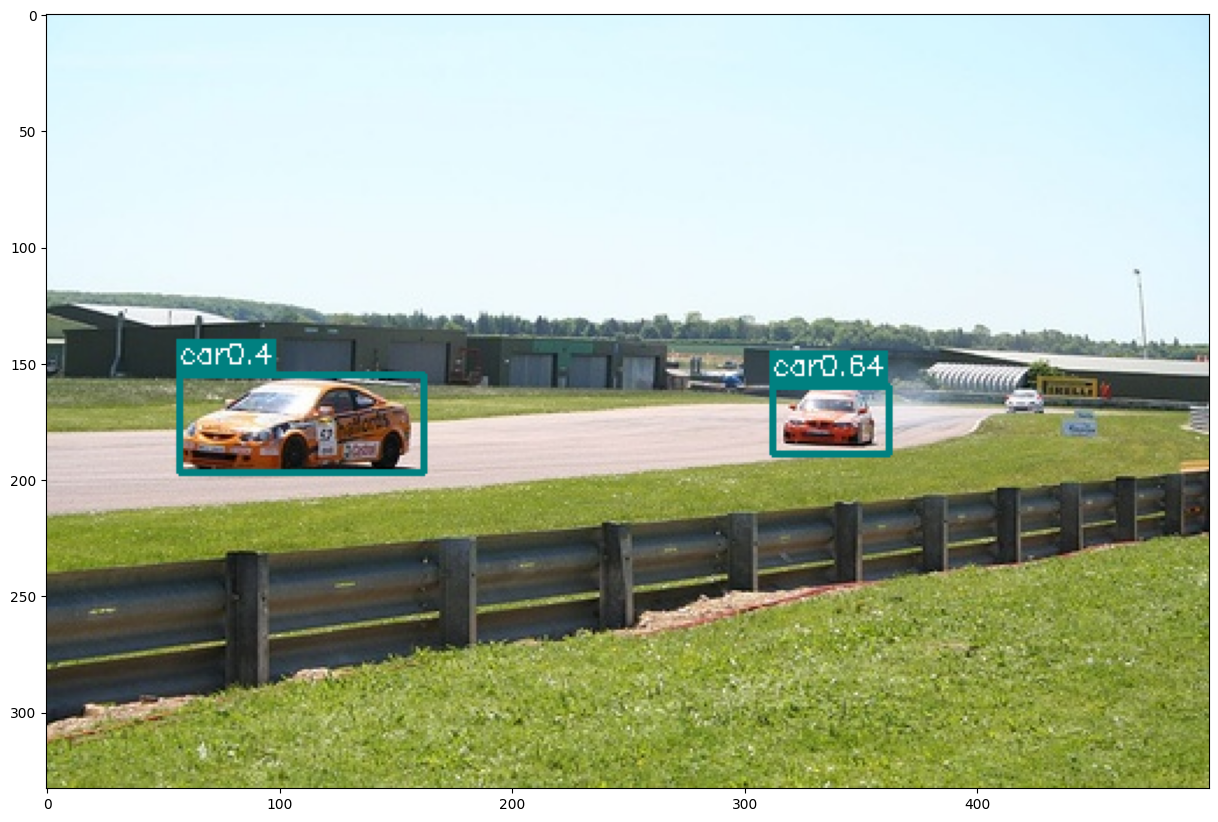

In [30]:
net.eval()

# select random image from val set
image_name = random.choice(val_dataset.fnames)
image = cv2.imread(os.path.join(file_root_val, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_val)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


# Kaggle submission (85%)

### Predict Result

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [22]:
root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
file_test = 'data/voc2007test.txt'

By using the test_evaluate function, you will obtain predictions for each image.

In [23]:
preds_submission = test_evaluate(net, test_dataset_file=file_test, img_root=root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:44<00:00, 30.10it/s]


The write_csv function will use preds_submission to write into a CSV file called 'result.csv'.

In [24]:
write_csv(preds_submission)

# Report (15%)
In your report, please include:

a. A brief discussion on your implementation.

b. Report the best train and validation accuracy in all of your experiments and discuss
any strategies or tricks you’ve employed.

c. Report the results for extra credits and also provide a discussion, if any.

# Extra Credit (15%)

• Pick a fun video like [**this one**](https://www.youtube.com/watch?v=xZGahvrep3o), run your detector on it (a subset of frames would be
OK), and produce a video showing your results.

• Try to replace the provided pre-trained network with a different one and train with
the YOLO loss on top to attempt to get better accuracy.

• Or any other methods that you try to improve the performance.

In [25]:
# !tensorboard --logdir=.\runs\training
# To view record use the cmd above

^C
